In [134]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os
from astropy.timeseries import LombScargle 
from jdcal import gcal2jd
from CosinorPy import cosinor, cosinor1

In [136]:
col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

folder_path = 'Data'
file_name = 'StA LD-DD 0118-0201-2024.txt'
file_path = os.path.join(folder_path, file_name)

df = pd.read_csv(file_path, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df = df[df["MonStatus"] == 1]


month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map))

spiders = []

for i in range(1, 33):
    if df[f"Sp{i}"].sum() > 5:
        spiders.append(i)
    if not i in spiders:
        df = df.drop([f"Sp{i}"], axis=1)


group_name = file_name.split(' ', 2)[0]
light_condition = file_name.split(' ', 2)[1]
start_date = file_name.split(' ', 2)[2].split('-', 1)[0]

path = group_name + "_" + light_condition + "_" + start_date + "_raster_plots"

if "-" in light_condition:
    li_con_1, li_con_2 = light_condition.split('-', 1)

display(df)

,Day,Time,Light,Sp3,Sp4,Sp5,Sp6,Sp7,Sp9,Sp10,...,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp24,Sp25
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-01-18 13:17:00,1,15,9,12,10,17,11,6,...,5,8,5,10,11,5,4,6,6,4
2,1,2024-01-18 13:18:00,1,0,0,1,0,1,1,0,...,1,0,1,4,0,0,0,1,0,0
3,1,2024-01-18 13:19:00,1,0,0,1,0,2,4,0,...,6,0,2,0,0,0,0,3,0,20
4,1,2024-01-18 13:20:00,1,0,4,3,0,1,0,0,...,4,0,1,1,0,0,0,0,0,9
5,1,2024-01-18 13:21:00,1,0,3,3,0,0,0,0,...,2,0,3,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,15,2024-02-01 17:33:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20418,15,2024-02-01 17:34:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,15,2024-02-01 17:35:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Raster plot code

In [138]:
light_days = []

for j in range(1, len(df['Day'].unique()) + 1):
    curr_df = df[df['Day']==j]

    if curr_df['Light'].sum() > 0:
        light_days.append(j)

print(light_days)

[1, 2, 3, 4, 5, 6, 7]


In [115]:
def raster_plot(sp, fig):
    for j in range(1, len(df['Day'].unique()) + 1):
        curr_df = df[df['Day']==j]

        """
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(len(df['Day'].unique()), 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == 1:
            ax.set_title(sp)
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == len(df["Day"].unique()):
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')
        """

    """
    file_path = os.path.join(path, f"{group_name}_{sp}_{light_condition}_{start_date}_raster_plot.png")
    plt.savefig(file_path)
    """
    plt.close()
    #plt.show()

In [117]:
if not os.path.exists(path):
    os.makedirs(path)


"""
x = f"Sp17"
fig = plt.figure(figsize=(4, 6))
raster_plot(x, fig)
"""


for i in spiders:
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    raster_plot(x, fig)

print("HOO", light_days)

HOO [1, 2, 3, 4, 5, 6, 7]


# Lomb-Scargle Code

In [229]:
def datetime_to_jd(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second
    _, jd = gcal2jd(year, month, day)
    jd += (hour + minute / 60 + second / 3600) / 24
    return jd


def period_LS_og(df, sp, first_day, last_day):
    
    curr_df = df[(df["Day"] >= first_day) & (df["Day"] <= last_day)]

    activity = np.array(curr_df[sp])

    time = curr_df['Time'].apply(datetime_to_jd)

    ls = LombScargle(time, activity)
    freq = np.linspace(0.1, 2, len(activity))
    power = ls.power(freq)

    max_power = np.max(power)
    max_freq = freq[np.argmax(power)]
    period = 1 / max_freq 
    period *= 24
    print(f"The Lomb-Scargle approximation of the period is {period} hours.")

    plt.figure(figsize=(10, 6))
    plt.plot(freq, power)
    plt.scatter(max_freq, max_power, s=75, c="red")
    plt.xlabel('Frequency (cycles/day)')
    plt.ylabel('Power')
    plt.title(f'Lomb-Scargle Periodogram for {sp}')
    plt.show()

def period_LS_2(df, sp, first_day, last_day):
    curr_df = df[(df["Day"] >= first_day) & (df["Day"] <= last_day)]

    activity = np.array(curr_df[sp])
    time = curr_df['Time'].apply(datetime_to_jd)

    ls = LombScargle(time, activity)
    freq = np.linspace(1/36, 100, len(activity))
    power = ls.power(freq)

    max_power = np.max(power)
    max_freq = freq[np.argmax(power)]

    periods = 1 / freq * 24
    power_new = power.copy()
    
    while max_freq > 3:
        max_power_indices = np.where(power_new == max_power)[0]
        power_new = np.delete(power_new, max_power_indices)
        #periods = np.delete(periods, max_power_indices)
        
        max_power = np.max(power_new)
        max_freq = freq[np.argmax(power_new)]
    
    period = 1 / max_freq
    period *= 24
    print(f"The Lomb-Scargle approximation of the period is {period} hours.")

    plt.figure(figsize=(10, 6))
    plt.plot(periods, power)
    plt.scatter(period, max_power, s=75, c="red")
    plt.xlabel('Period (hours)')
    plt.ylabel('Power')
    plt.xlim(0, 36)
    plt.xticks(np.arange(0, 37, 6))
    plt.title(f'Lomb-Scargle Periodogram for {group_name} {sp.split("p", 2)[1]}')
    plt.show()

def period_LS_1(df, sp, first_day, last_day):
    curr_df = df[(df["Day"] >= first_day) & (df["Day"] <= last_day)]

    activity = np.array(curr_df[sp])
    time = curr_df['Time'].apply(datetime_to_jd)

    ls = LombScargle(time, activity)
    freq = np.linspace(1/36, 100, len(activity))
    power = ls.power(freq)

    max_power = np.max(power)
    max_freq = freq[np.argmax(power)]

    periods = 1 / freq * 24

    """
    while max_freq > 3:
        max_power_indices = np.where(power == max_power)[0]
        power = np.delete(power, max_power_indices)
        periods = np.delete(periods, max_power_indices)
        
        max_power = np.max(power)
        max_freq = freq[np.argmax(power)]
    """
    
    period = 1 / max_freq
    period *= 24
    print(f"The Lomb-Scargle approximation of the period is {period} hours.")

    plt.figure(figsize=(10, 6))
    plt.plot(periods, power)
    plt.scatter(period, max_power, s=75, c="red")
    plt.xlabel('Period (hours)')
    plt.ylabel('Power')
    plt.xlim(0, 36)
    plt.xticks(np.arange(0, 37, 6))
    plt.title(f'Lomb-Scargle Periodogram for {group_name} {sp.split("p", 2)[1]}')
    plt.show()

The Lomb-Scargle approximation of the period is 24.284804280342225 hours.


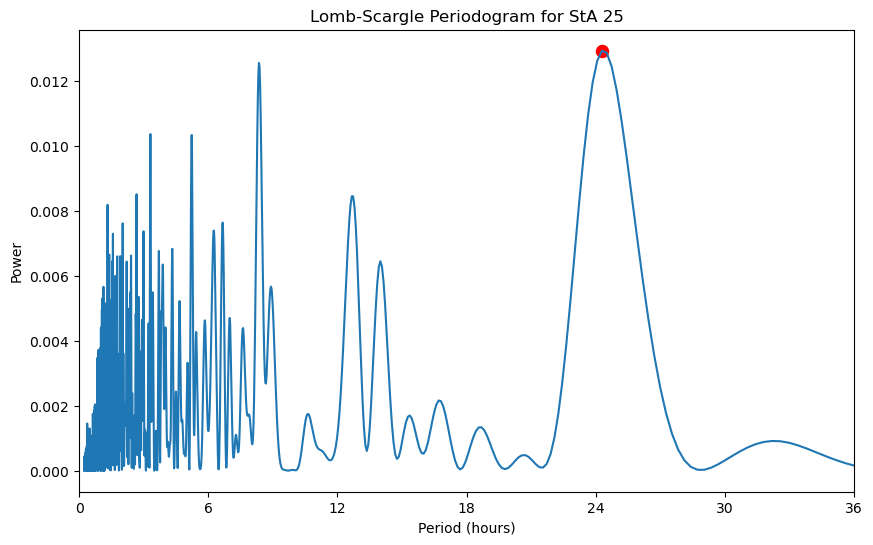

In [235]:
#period_LS_og(df, 'Sp18', 2, 7)
#period_LS_1(df, 'Sp18', 2, 7)
period_LS_2(df, 'Sp25', 8, 15)

# CSV dataframe

In [ ]:
data_report = pd.DataFrame(columns=['Group', 'SpiderN', 'Period', 'Date'])

group_info = [group_name for i in range(len(spiders))]

data_report['Group'] = group_info

data_report['SpiderN'] = spiders

#for i, data in enumerate(new_data):
#    df.loc[len(df)] = [group_list[i]] + data[1:]

data_report

#period_LS(df, 'Sp17', 1, 7)

# Raster plot separator

In [ ]:
"""

raster plot: LD/DD/LL separation 
user must manually put in day range and LD/LL/DD (may automate second part later)
Parameters that I changed: first day that you would like to select (inclusive), last 

"""
def raster_separate(first_day, last_day, expr_type, sp, fig):
    
    for j in range(first_day, last_day + 1):
        curr_df = df[df['Day']==j]
        #display(curr_df[200:205])
        
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(last_day + 1, 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == first_day:
            ax.set_title(sp)
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == last_day:
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')

    if not os.path.exists("Raster_plots"):
            os.makedirs("Raster_plots")
    
    file_path = os.path.join("Raster_plots", f"{sp}_raster_plot_{expr_type}.png")
    plt.savefig(file_path)
    #plt.close()
    plt.show()

In [ ]:
for i in range(25, 26):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    raster_separate(3, 7, "DD", x, fig)